<h1 style='color:blue'>Forecasting_With_ARIMA_Models</h1>

In this notebook we use the famous ARIMA model to make time series forecasting. We will use SARIMA model as well to capture the seasonal behaviour of data.

In particular We will use the popular Box-Jenkins method for the implementation of the ARIMA Model. The Steps involved are:
1. Identification
2. Estimation
3. Model Diagnostics

In [32]:
# import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#loading the data that we processed after eda
train = pd.read_csv('data/train.csv', parse_dates=[0], index_col=[0])
train_original = pd.read_csv('data/train_original', parse_dates=['Datetime'], index_col='Datetime')
test_original = pd.read_csv('data/test_original', parse_dates=['Datetime'], index_col='Datetime')

In [3]:
train.head()

,ID,Count,year,month,day,Hour,day_of_week,weekend
Datetime,,,,,,,,
2012-08-25,11.5,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,35.5,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,59.5,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,83.5,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,107.5,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


### Identification

In this step firstly we check if the given time series is stationary using the dickey fuller test. If it is not stationary we will make it stationary using differencing and find the order of d required to make it stationary. After that we will find the orer of AR and MA respectively

In [17]:
from matplotlib.pyplot import rcParams
from utility import evaluate_model, dicker_test
rcParams['figure.figsize'] = 20, 10
df = train.copy()

In [23]:
def viz_stationary(timeseries):
    #determine rolling statistics 24 hours on each day
    rolmean = timeseries.rolling(window = 24).mean()
    rolstd = timeseries.rolling(window = 24).std()
    
    #plot rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label ='Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label='Rolling Std')
    plt.legend(loc = 'best')
    plt.title("Rolling Mean and Standard Deviation")
    plt.show()
    
def dicker_test(timeseries):
    #perform dickey fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P- Value', '#Lags Used', 'NUmber of Observation Used'])
        
    print('=======================================')
    print('Results of Dicker Fuller Test:')
    print('=======================================')
        
    for key, value in dftest[4].items():
        dfoutput['Critical value ({})'.format(key)] = value
        
    print(dfoutput)
    print('=======================================')
    print('=======================================')

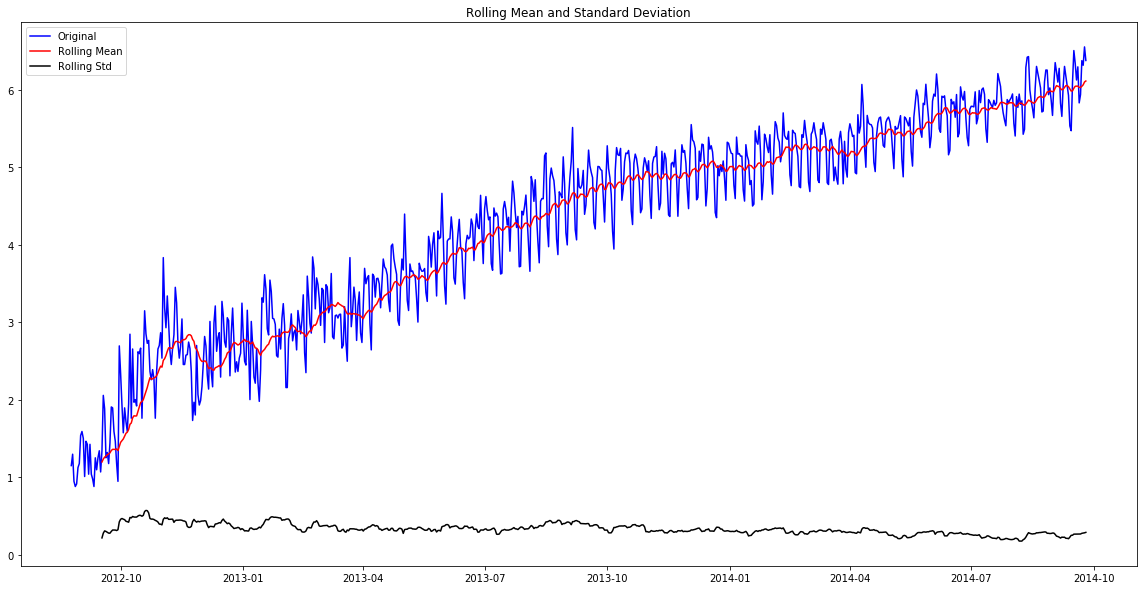

Results of Dicker Fuller Test:
Test Statistic                 -2.413296
P- Value                        0.138019
#Lags Used                     20.000000
NUmber of Observation Used    741.000000
Critical value (1%)            -3.439206
Critical value (5%)            -2.865448
Critical value (10%)           -2.568851
dtype: float64


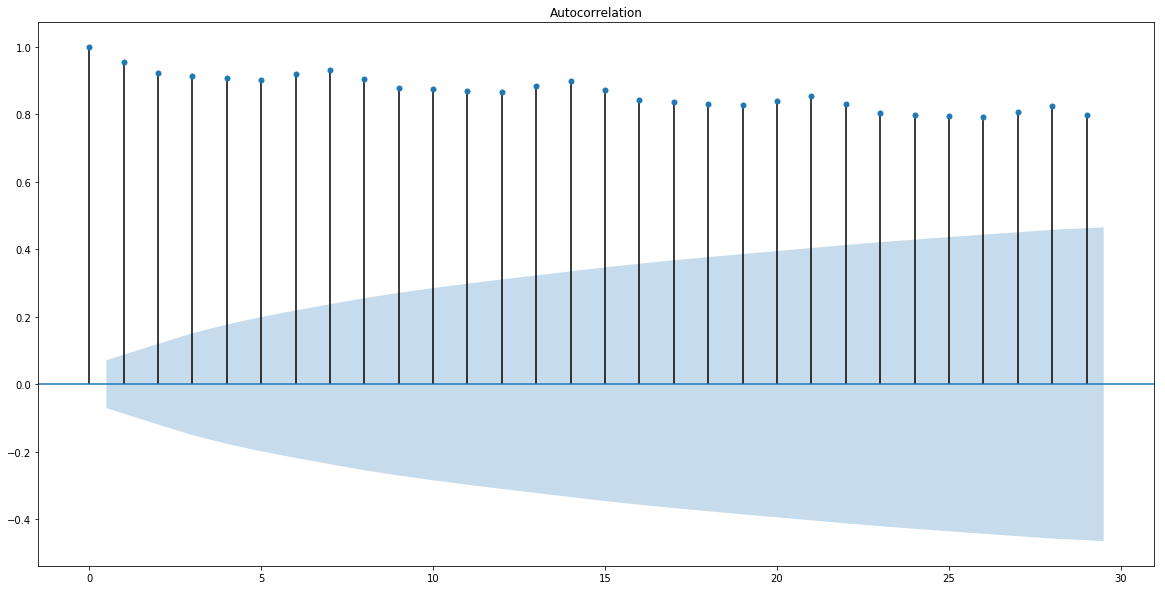

In [24]:
#applying log transformation
df_log = np.log(df.Count)

# Original Series
viz_stationary(df_log)
plot_acf(df_log)
dicker_test(df_log)
plt.show()

The time series is not stationary by itself as p value is not less then 0.05 and acf plot also supports this fact.

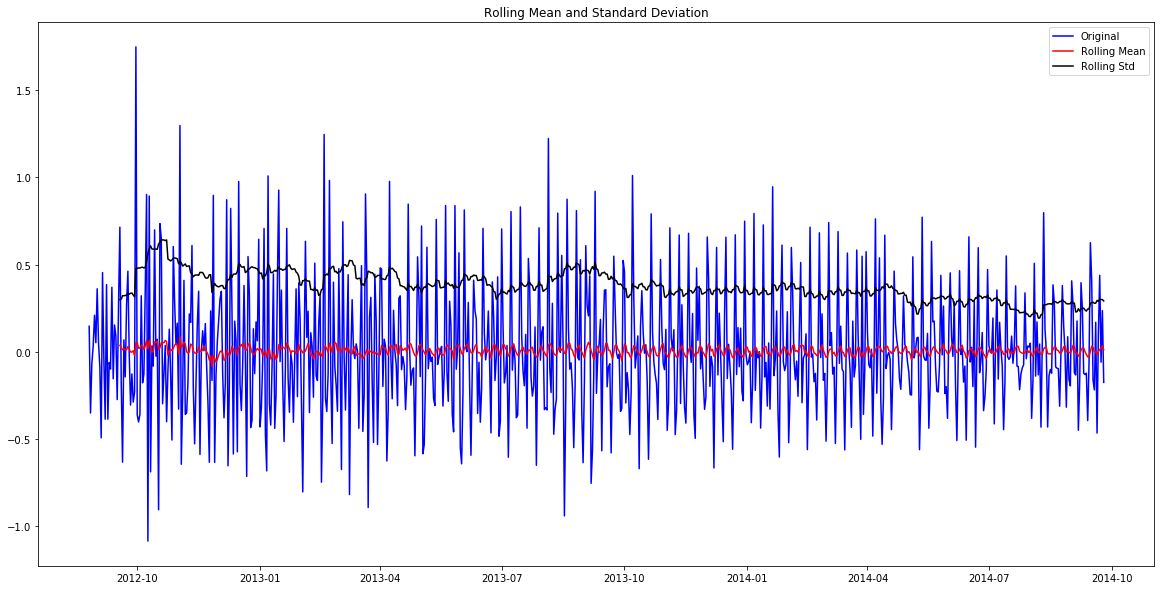

Results of Dicker Fuller Test:
Test Statistic               -8.877418e+00
P- Value                      1.346196e-14
#Lags Used                    1.900000e+01
NUmber of Observation Used    7.410000e+02
Critical value (1%)          -3.439206e+00
Critical value (5%)          -2.865448e+00
Critical value (10%)         -2.568851e+00
dtype: float64


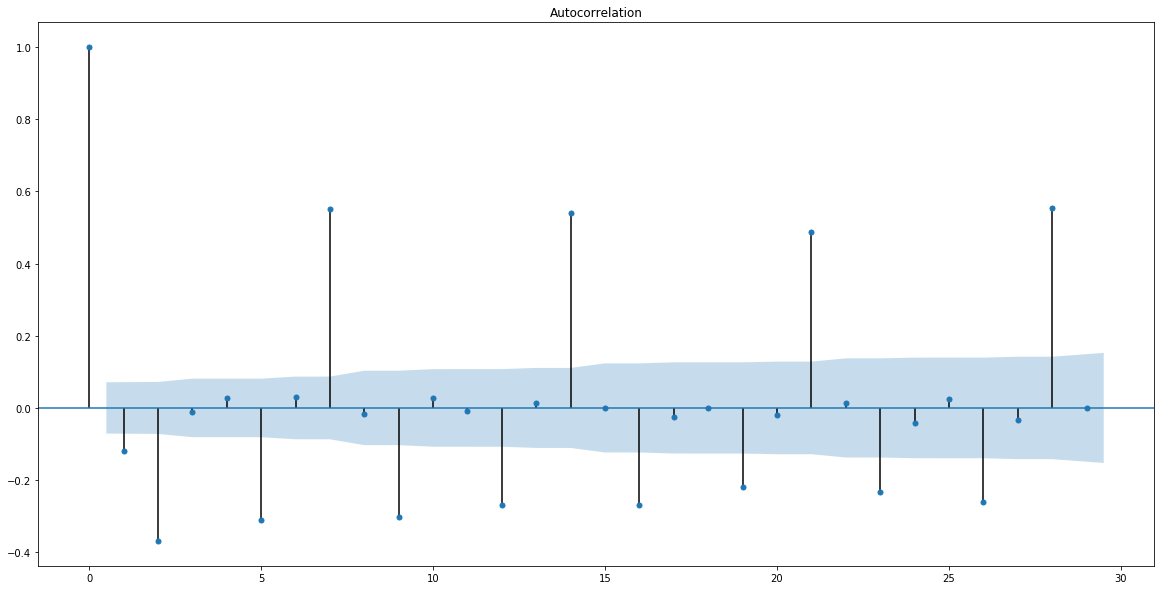

In [25]:
#1st Differencing
diff1 = df_log.diff()
viz_stationary(diff1)
plot_acf(diff1.dropna())
dicker_test(diff1.dropna())

d = 1 makes the time series stationary, we can also see that there is a seasionality in interval of 7 units

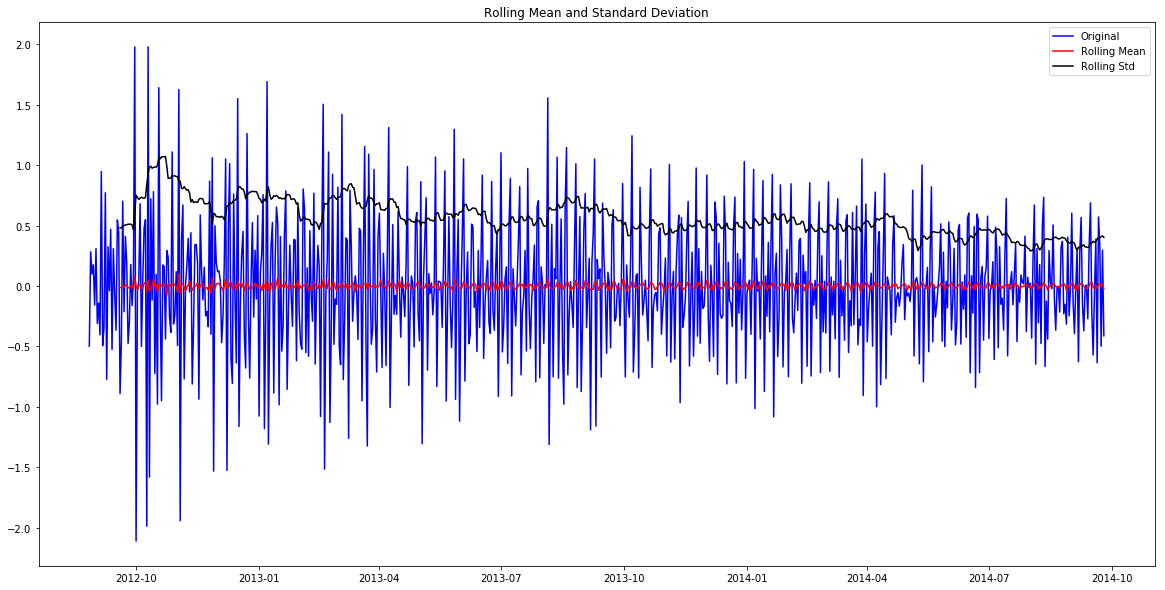

Results of Dicker Fuller Test:
Test Statistic               -1.141464e+01
P- Value                      7.111454e-21
#Lags Used                    2.000000e+01
NUmber of Observation Used    7.390000e+02
Critical value (1%)          -3.439230e+00
Critical value (5%)          -2.865459e+00
Critical value (10%)         -2.568857e+00
dtype: float64


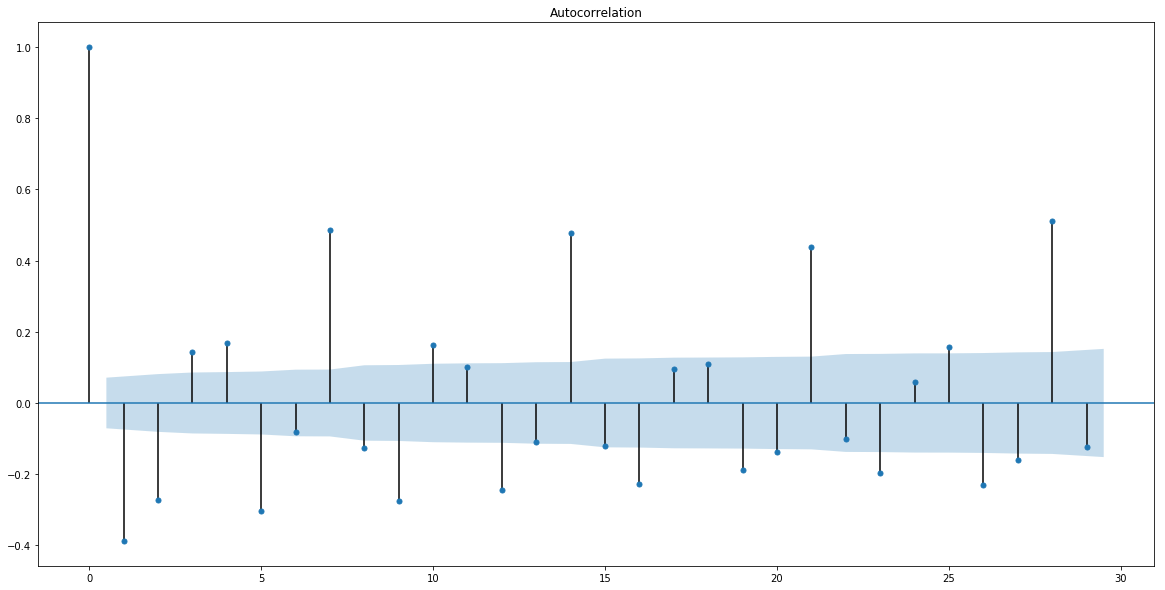

In [26]:
# # 2nd Differencing
diff2 = df_log.diff().diff()
viz_stationary(diff2)
dicker_test(diff2.dropna())
plot_acf(diff2.dropna())
plt.show()

for d = 2, the 1st lag of acf plot reaches too negative suggesting over differenced, so we choose d=1. Alternatively lets use other methods to find the order of d

In [27]:
from pmdarima.arima.utils import ndiffs
y = df.Count

#ADF test
print('ADF test: {}'.format(ndiffs(y, test='adf')))
#KPSS test
print('KPSS test: {}'.format(ndiffs(y, test='kpss')))
#PP test
print('PP test: {}'.format(ndiffs(y, test = 'pp')))

ADF test: 1
KPSS test: 1
PP test: 0


Hence, we can be assured that our estimation was right.

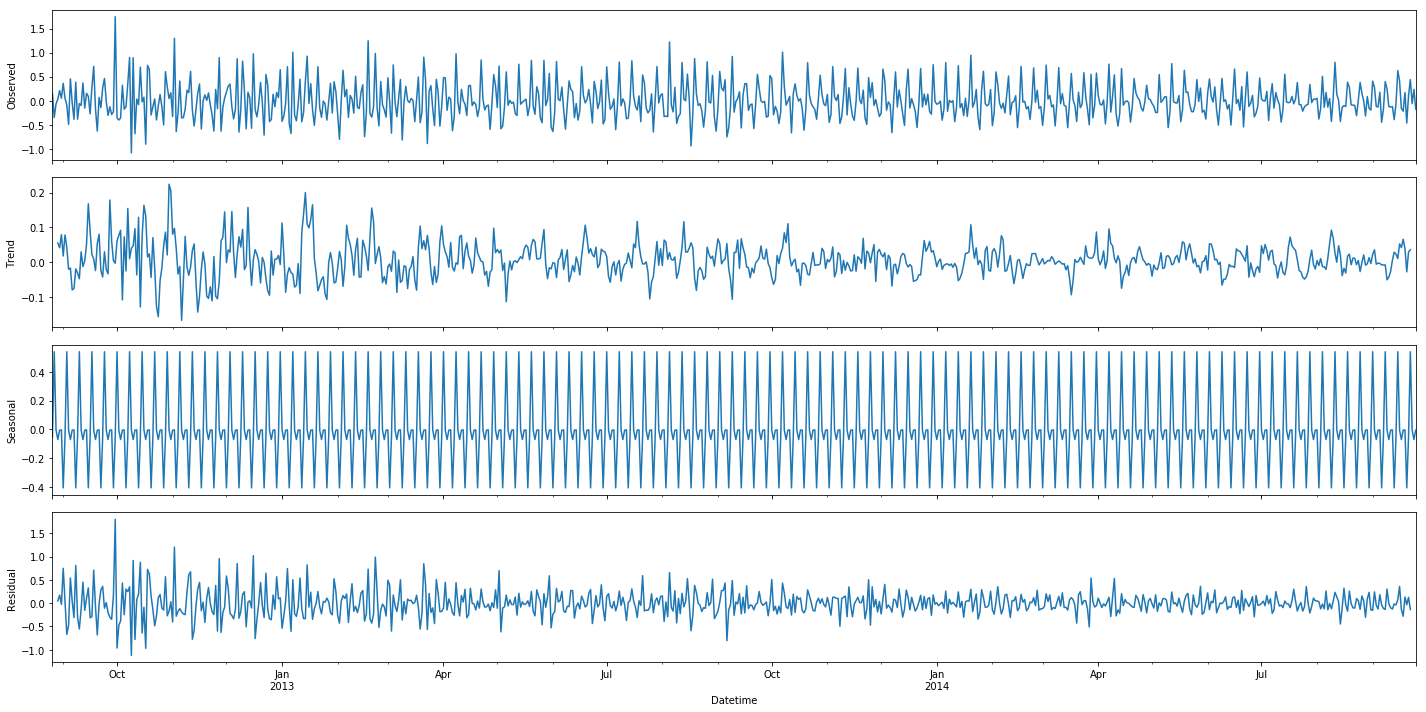

In [33]:
decomp = seasonal_decompose(diff1.dropna())
decomp.plot();

In [34]:
dicker_test(decomp.resid.dropna())

Results of Dicker Fuller Test:
Test Statistic               -1.406868e+01
P- Value                      2.966997e-26
#Lags Used                    2.000000e+01
NUmber of Observation Used    7.340000e+02
Critical value (1%)          -3.439290e+00
Critical value (5%)          -2.865486e+00
Critical value (10%)         -2.568871e+00
dtype: float64


From the above stats, it can be interpreted that the residuals are stationary

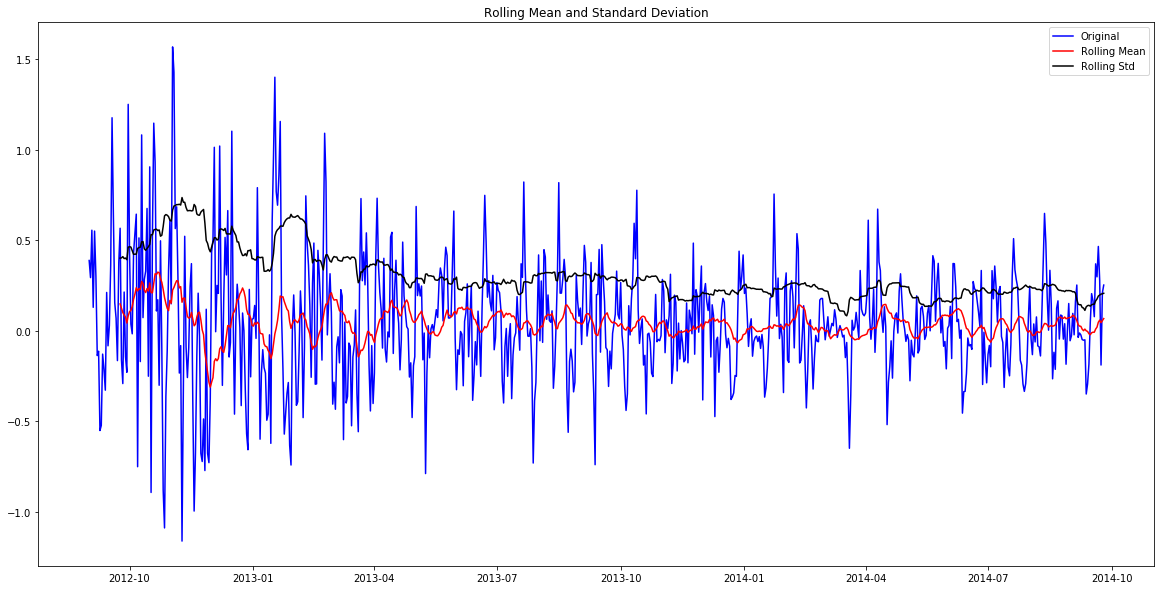

Results of Dicker Fuller Test:
Test Statistic               -9.162824e+00
P- Value                      2.506240e-15
#Lags Used                    2.000000e+01
NUmber of Observation Used    7.340000e+02
Critical value (1%)          -3.439290e+00
Critical value (5%)          -2.865486e+00
Critical value (10%)         -2.568871e+00
dtype: float64


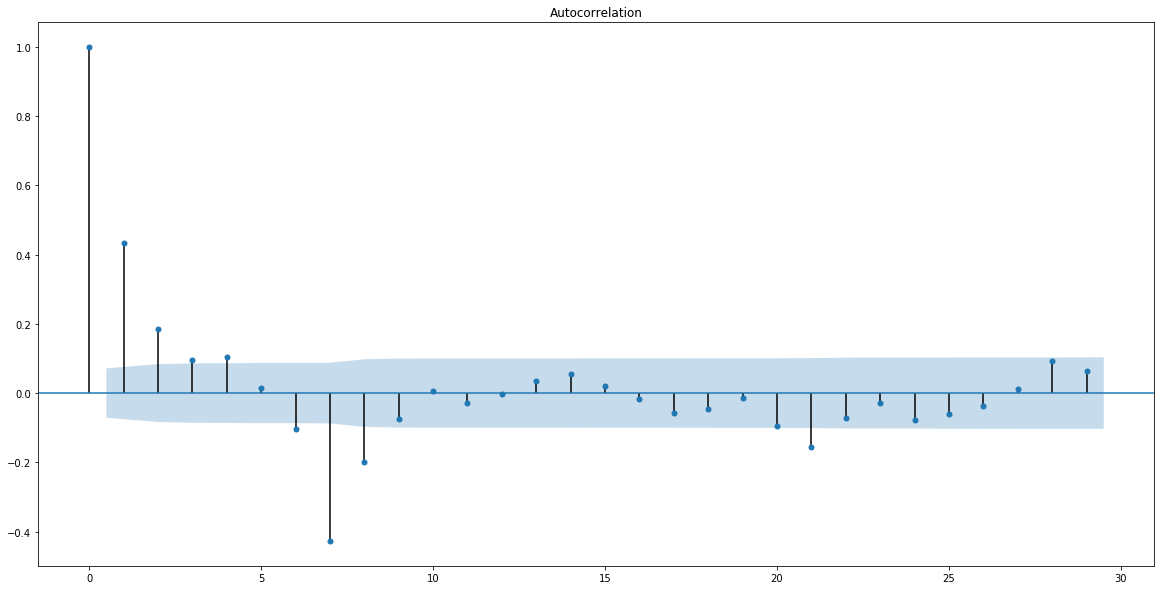

In [36]:
#Differencing with seasonal
diff1_s = df_log.diff(7)
viz_stationary(diff1_s)
plot_acf(diff1_s.dropna())
dicker_test(diff1_s.dropna())

#### Finding the order of AR term (p) and MA term (q)

We can find order of AR model using Partial Auto Correlation function and MA model using Autocorrelation function. Alternatively we can use Information Criteria to find the orders too (AIC and BIC)

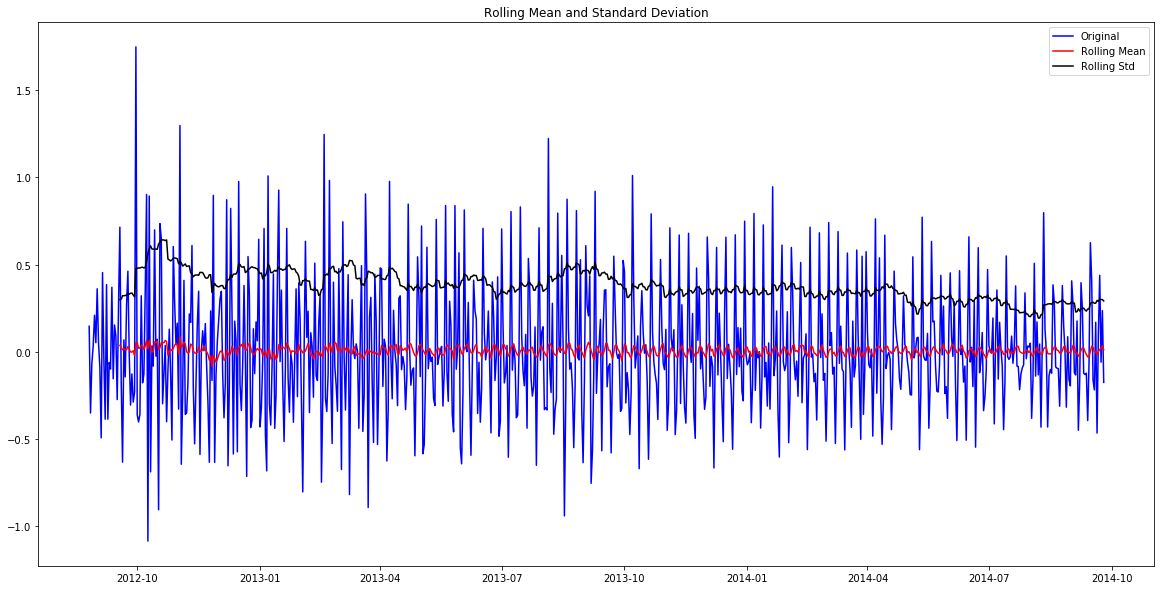

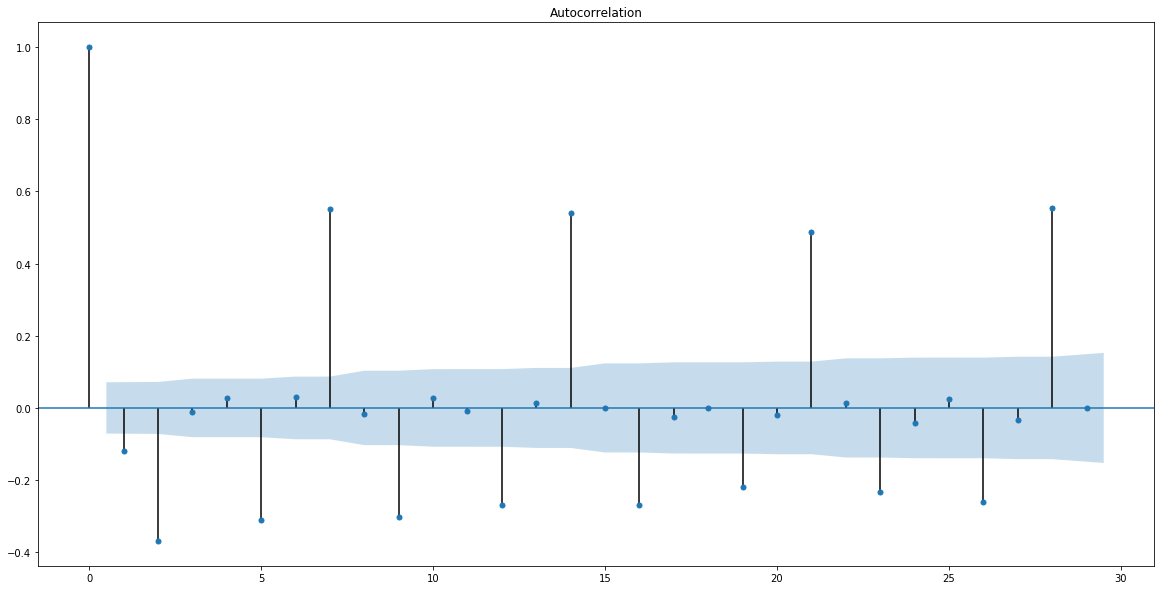

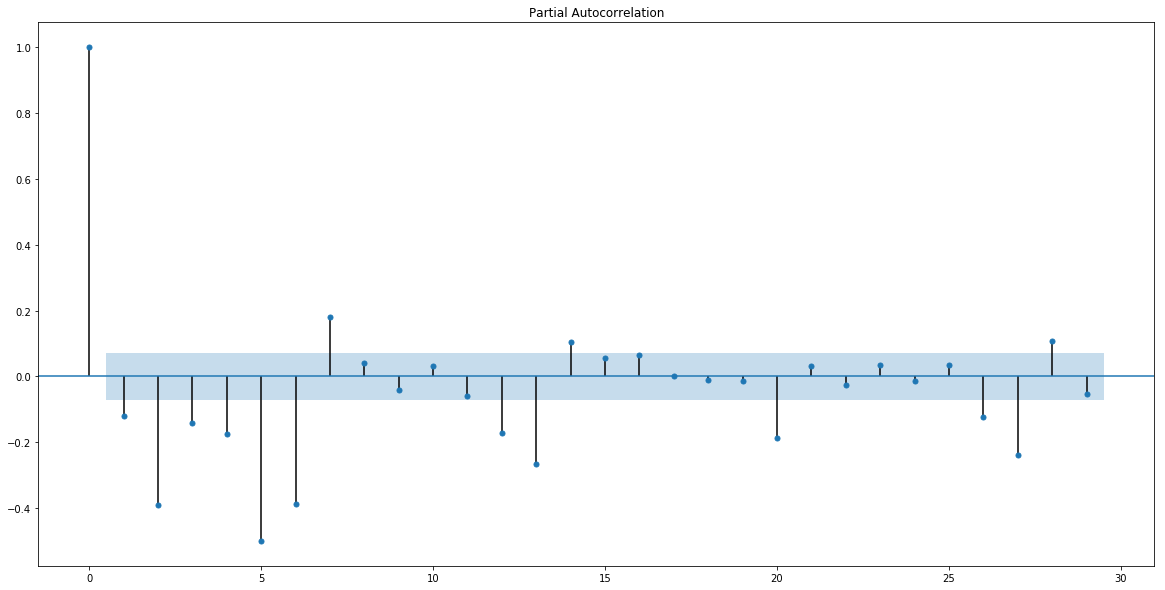

In [37]:
#first order differencing
viz_stationary(df_log.diff())
plot_acf(df_log.diff().dropna())
plot_pacf(df_log.diff().dropna())
plt.show()

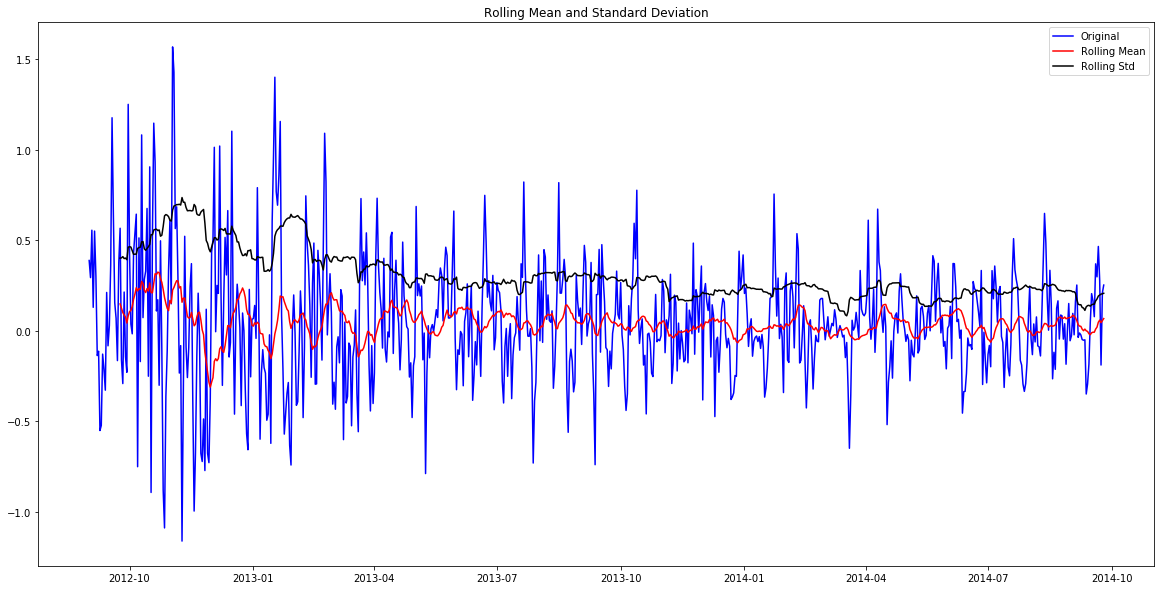

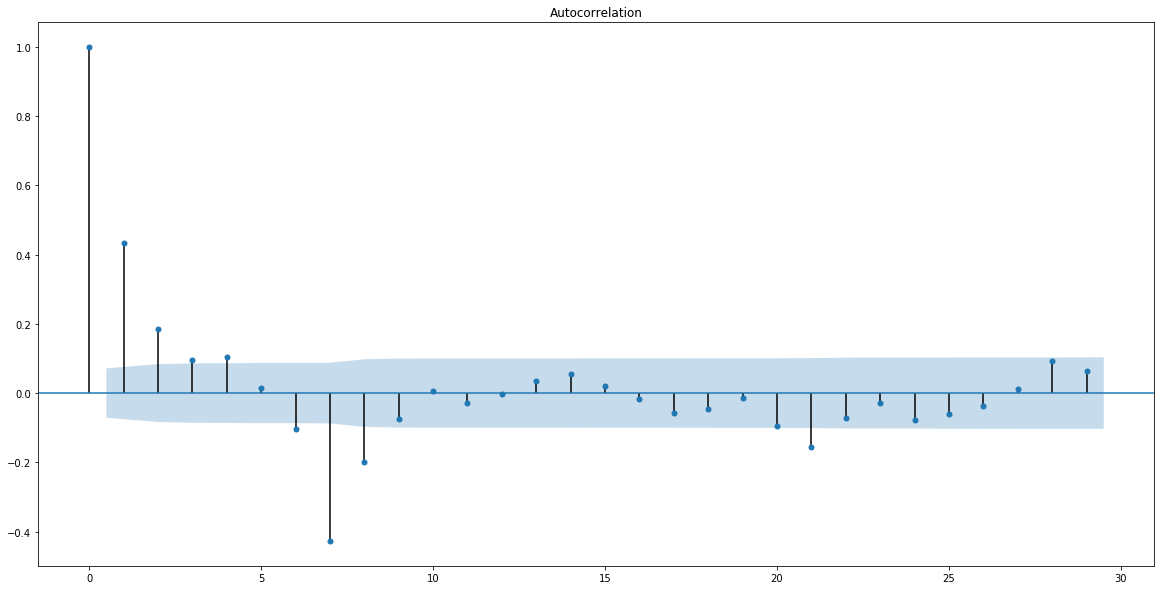

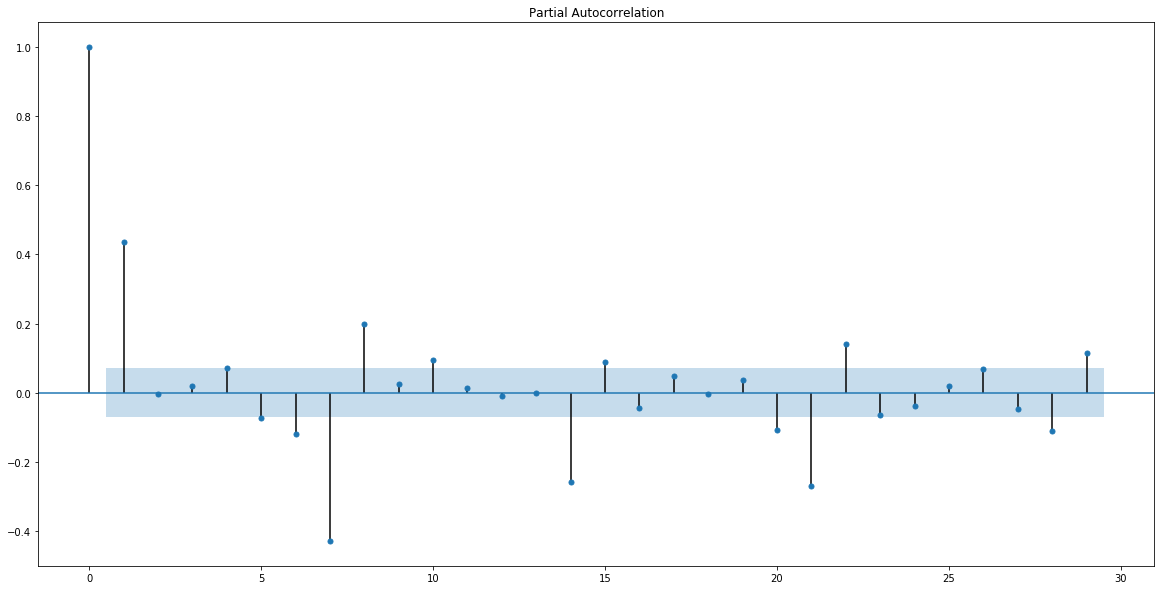

In [38]:
#differencing with seasonal
viz_stationary(df_log.diff(7))
plot_acf(df_log.diff(7).dropna())
plot_pacf(df_log.diff(7).dropna())
plt.show()

We can spot that there are 7 lags above the significance level in pacf with the regular differencing However when remove it we can only one lag, so we have our value p = 1. similalrly the above plot we can take value of q = 2.

Alternatively, lets use AIC and BIC to find the order of model

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

for p in range(4):
    for q in range(4):
        try:
            model = SARIMAX(diff1_s, order = (p,0,q))
            result = model.fit()
            print(p,q, result.aic, result.bic)
            
        except:
            print(p, q, None, None)

0 0 506.11187574728643 510.7478223029731
0 1 369.38179655835614 378.65368966972943
0 2 347.16872935099076 361.0765690180507
0 3 347.8052717001757 366.34905792292227
1 0 340.87707655737336 350.14896966874664
1 1 342.8599795951533 356.7678192622132
1 2 344.19176956759975 362.7355557903463
1 3 345.9704998335015 369.1502326119347
2 0 342.8622363997723 356.77007606683225
2 1 344.8724666951455 363.41625291789205
2 2 257.9189226140477 281.09865539248096
2 3 311.5809758476848 339.39665518180465
3 0 344.24093929431933 362.7847255170659
3 1 345.6846552845004 368.86438806293364
3 2 245.64188784643392 273.4575671805538
3 3 257.4719005721181 289.92352646192467


In [40]:
for p in range(4):
    for q in range(4):
        try:
            model = SARIMAX(df_log, order = (p,1,q))
            result = model.fit()
            print(p,q, result.aic, result.bic)
            
        except:
            print(p, q, None, None)

0 0 671.022867344605 675.6575007024667
0 1 558.318805991304 567.5880727070273
0 2 408.5308569863051 422.43475705989016
0 3 410.3058056201076 428.84433905155436
1 0 662.2364512126235 671.5057179283468
1 1 464.4040730066845 478.30797308026956
1 2 410.4026153489103 428.941148780357
1 3 398.3116066359837 421.48477342529213
2 0 540.2437721289432 554.1476722025283
2 1 397.8901581731769 416.4286916046237
2 2 399.20952884399026 422.3826956332987
2 3 370.45590894430734 398.26370909147744
3 0 527.4158054012873 545.954338832734
3 1 399.856229817654 423.02939660696245
3 2 400.48301984127477 428.29081998844487
3 3 282.64566416065225 315.088097665684


Here using AIC and BIC We have our order 3,1,3 and with the plots we had 1,1,2 lets try out both of them for now

### Estimation

In this step we use data to train the model coefficients and we choose between the models using AIC and BIC

In [41]:
from statsmodels.tsa.arima_model import ARIMA

#1,1,2 ARIMA Model
model = ARIMA(df_log, order = (1,1,2))
model_fit1 = model.fit(disp=0)

#full output
print(model_fit1.summary())

#only coefficients
print('===Params===')
print(model_fit1.params)

#Aic and Bic
print("===AIC and BIC====")
print(model_fit1.aic, model_fit1.bic)

                             ARIMA Model Results                              
Dep. Variable:                D.Count   No. Observations:                  761
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -192.577
Method:                       css-mle   S.D. of innovations              0.311
Date:                Thu, 23 Jan 2020   AIC                            395.154
Time:                        05:18:05   BIC                            418.328
Sample:                    08-26-2012   HQIC                           404.078
                         - 09-25-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0066      0.001      5.038      0.000       0.004       0.009
ar.L1.D.Count    -0.0098      0.067     -0.145      0.885      -0.142       0.122
ma.L1.D.Count    -0.4105      0.057     

In [45]:
#3,1,3 ARIMA Model
model = SARIMAX(df_log, trend='c', order = (3,1,3))
model_fit = model.fit(disp=0)

#full output
print(model_fit.summary())

#only coefficients
print('===Params===')
print(model_fit.params)

#Aic and Bic
print("===AIC and BIC====")
print(model_fit.aic, model_fit.bic)

                           Statespace Model Results                           
Dep. Variable:                  Count   No. Observations:                  762
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -137.898
Date:                Thu, 23 Jan 2020   AIC                            291.796
Time:                        05:22:16   BIC                            328.873
Sample:                    08-25-2012   HQIC                           306.072
                         - 09-25-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0059      0.001      7.735      0.000       0.004       0.007
ar.L1          0.1614      0.033      4.853      0.000       0.096       0.227
ar.L2         -0.7211      0.015    -48.005      0.0

The model's AIC and BIC has reduced with (3,1,3) and the P valuse are also less then 0.05. 
Lets plot the residual to ensure that there are no patterns(observation for constant variance and mean)

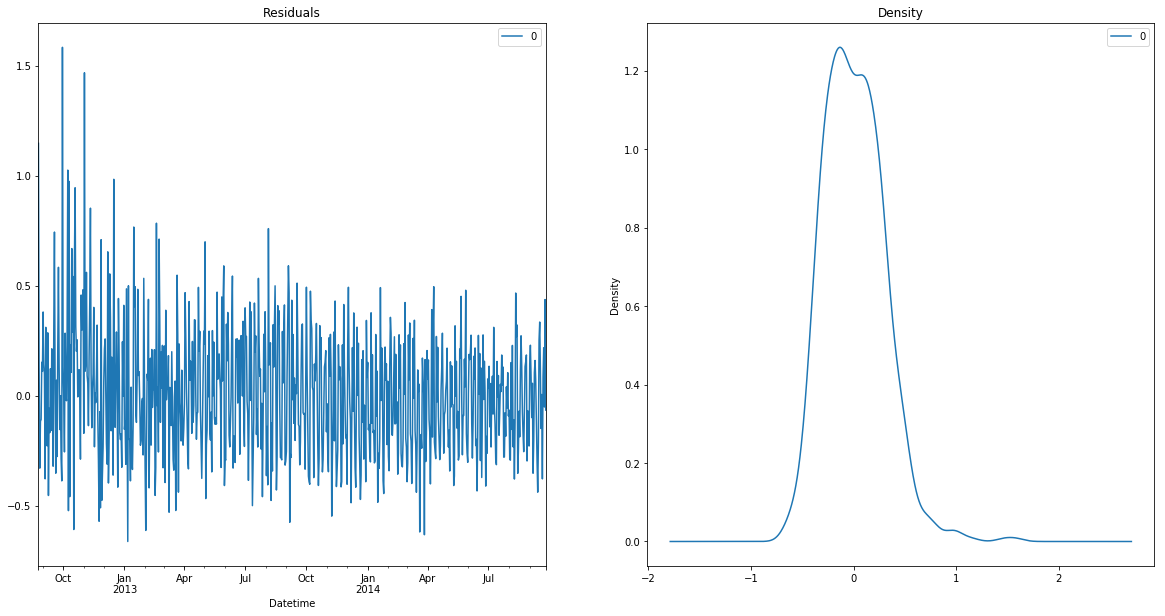

In [46]:
#plot the residuals errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax = ax[0])
residuals.plot(kind='kde',title='Density', ax=ax[1])
plt.show()

The residual error seems fine with near zero mean and uniform variance. Now lets plot the actuals against the fitted values.

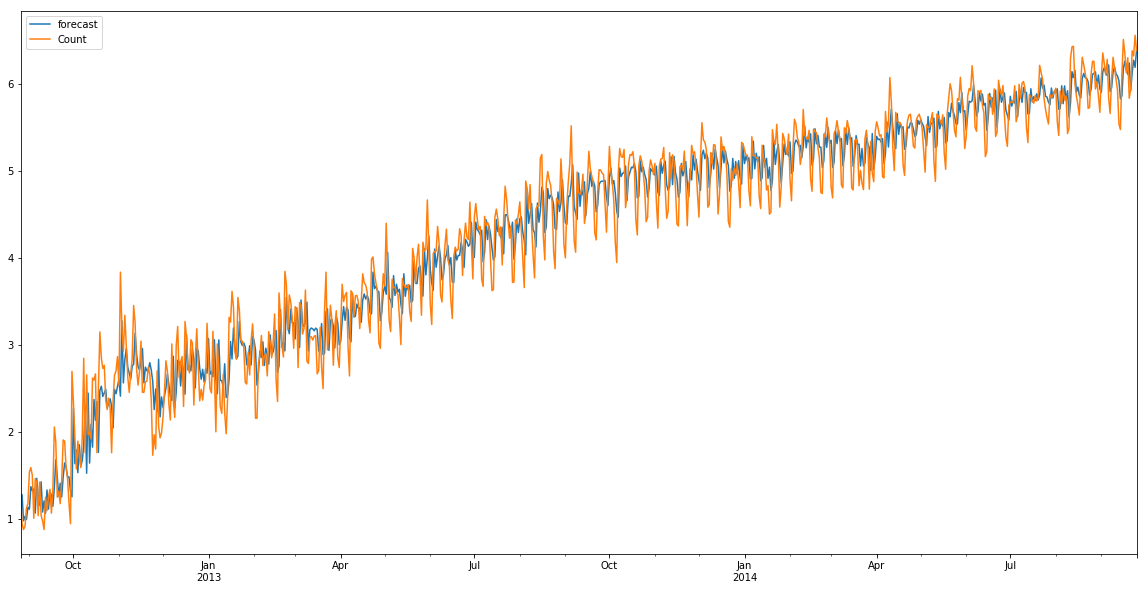

In [72]:
#Actual vs Fitted
model_fit1.plot_predict(dynamic = False)
plt.show()

In [67]:
#making insample prediction for last 115 values
forecast = model_fit.get_prediction(start = -115)

In [68]:
#forecast mean
mean_forecast = forecast.predicted_mean

#get confidence intervals of forecast
confidence_intervals = forecast.conf_int()

In [69]:
lower_count = confidence_intervals['lower Count']
upper_count = confidence_intervals['upper Count']

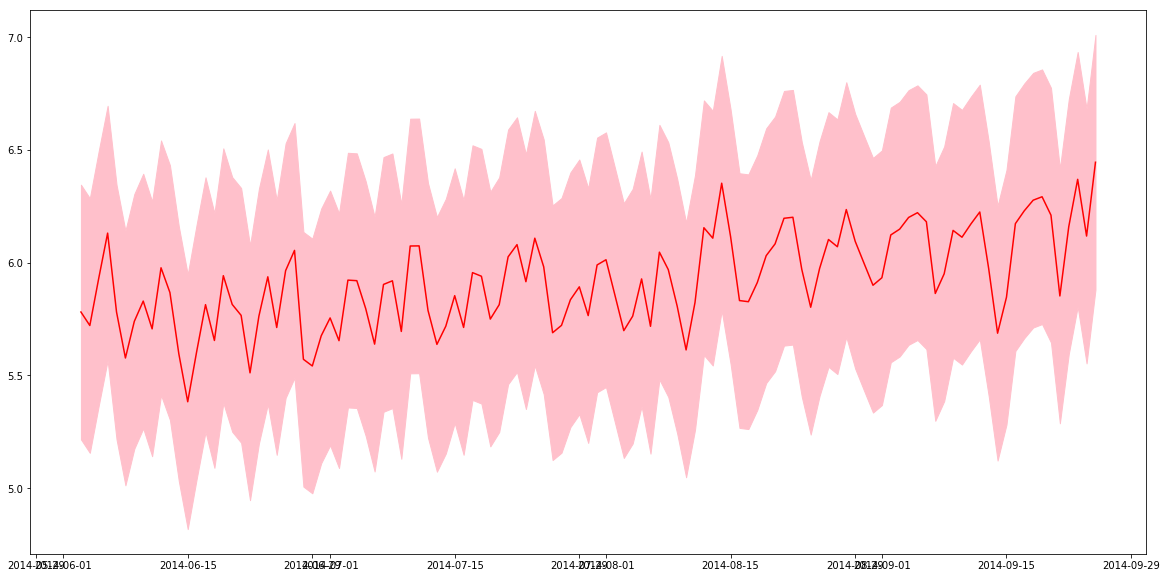

In [70]:
plt.plot(mean_forecast.index, mean_forecast.values, color ='red', label='forecast')
plt.fill_between(mean_forecast.index, lower_count, upper_count, color='pink')
plt.show()

#### Using Out of Time Cross validation

In [119]:
from statsmodels.tsa.stattools import acf

#creating training and test
x = int(0.85*len(df_log))
train = df_log[:x]
valid = df_log[x:]

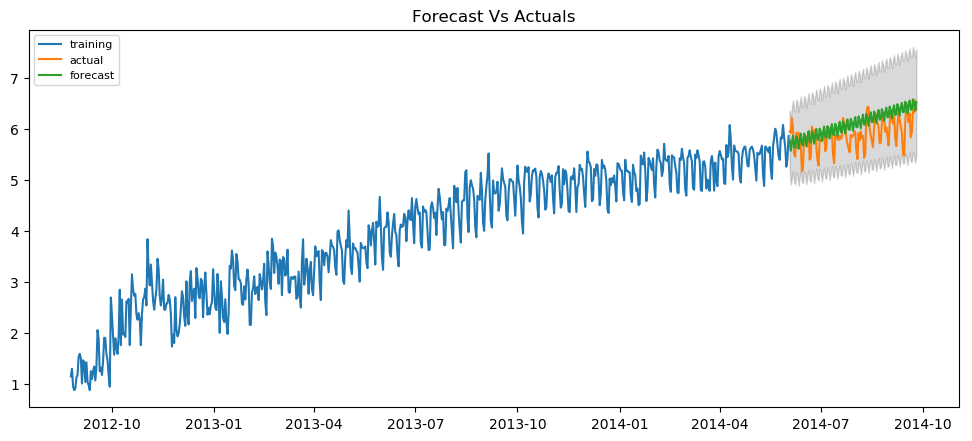

In [122]:
#build the model
model = ARIMA(train, order=(3,1,3))
fitted = model.fit(disp=-1)

#making forcast with 95% confidence
fc, se, conf = fitted.forecast(len(valid), alpha=0.05)

#converting predicition to pandas series
fc_series=pd.Series(fc, index=valid.index)
lower_series = pd.Series(conf[:,0], index=valid.index)
upper_series = pd.Series(conf[:,1], index=valid.index)

#plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label = 'training')
plt.plot(valid, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series,
                 upper_series,color = 'k', alpha =.15)
plt.title('Forecast Vs Actuals')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()

From the given chart the ARIMA model seems to give directionally correct forecast and the acutal observed values lie within 95% confidence band which is completely fine.

In [86]:
evaluate_model(fc, test.values)

Evaluation Metrics:
--------------------
RMS:0.3232899537413528
MAPE:0.046102730559581015
MPE:0.03491484914926991
--------------------


In [87]:
#see the residuals
residuals = fitted.resid
mae = np.mean(np.abs(residuals))
print(mae)

0.23880894972024003


Around 4.6% MAPE means our model is 95.4% accurate for the remaining 15% of observations. Finally lets, make the prediction using ARIMA model

#### Final Prediction

In [92]:
test = pd.read_csv('data/test.csv', parse_dates=['Datetime'], index_col='Datetime')

In [123]:
#build the model
model = ARIMA(df_log, order=(3,1,3))
fitted = model.fit(disp=-1)

prediction, se, comfint = fitted.forecast(len(test))

In [124]:
#converting predicition to pandas series
prediction_series=pd.Series(prediction, index=test.index)
lower_series = pd.Series(comfint[:,0], index=test.index)
upper_series = pd.Series(comfint[:,1], index=test.index)

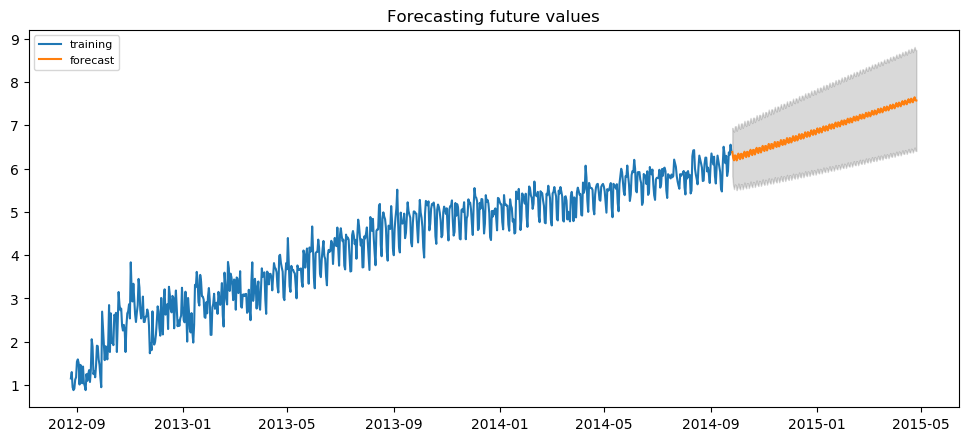

In [125]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_log, label = 'training')
# plt.plot(test, label='actual')
plt.plot(prediction_series, label='forecast')
plt.fill_between(lower_series.index, lower_series,
                 upper_series,color = 'k', alpha =.15)
plt.title('Forecasting future values')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()

Lets visualize previously validation part along with this future prediction 

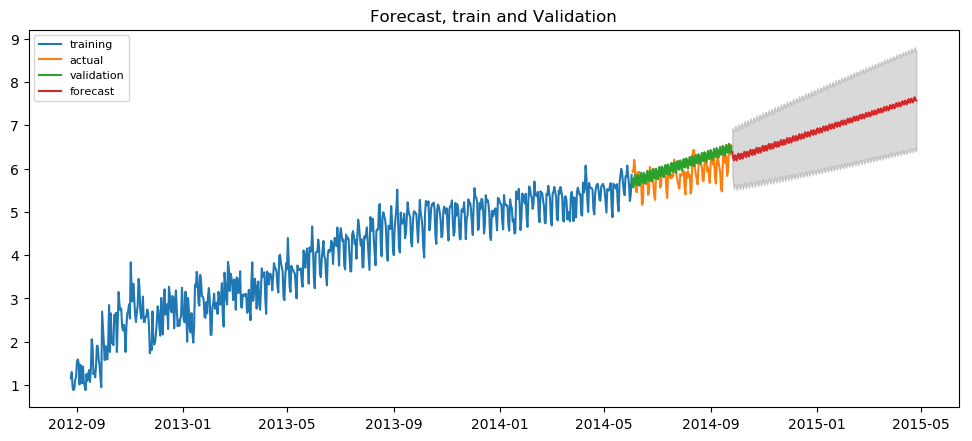

In [127]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label = 'training')
plt.plot(valid, label='actual')
plt.plot(fc_series, label='validation')
plt.plot(prediction_series, label='forecast')
plt.fill_between(lower_series.index, lower_series,
                 upper_series,color = 'k', alpha =.15)
plt.title('Forecast, train and Validation')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()

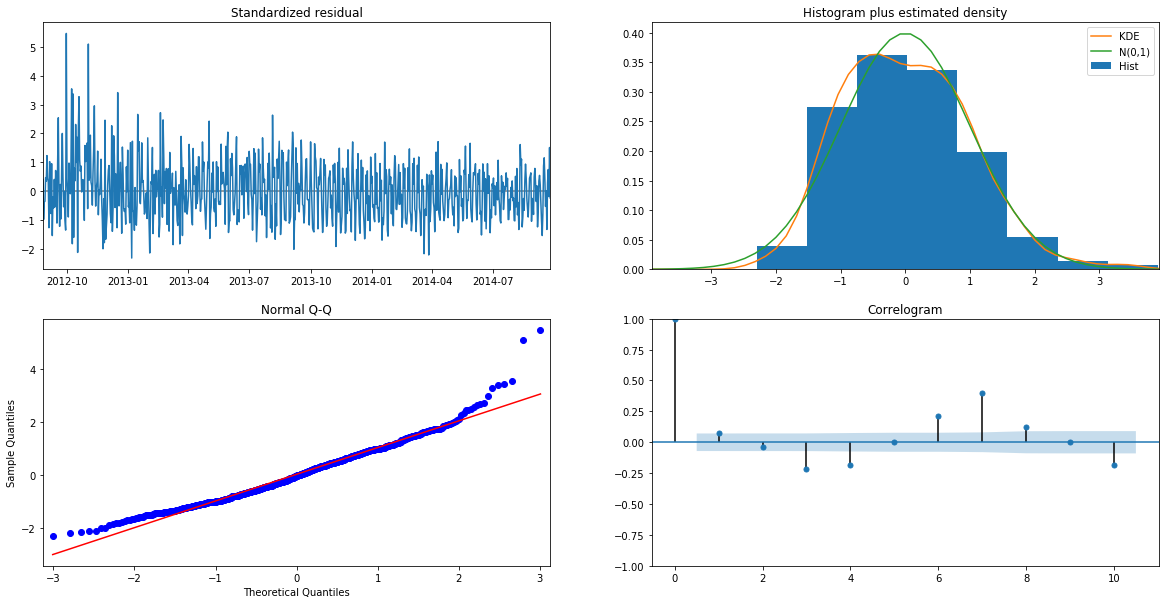

In [134]:
#model diagnostics
model_fit.plot_diagnostics()
plt.show()

After plotting diagnostic we can see that the correlogram has number of lags above significance level.
Since the data is seasonal we will always have correlated residuals left if we try to fit ARIMA model to it. This means we are not using all the information of the data and hence we are not making the best prediction possible